In [1]:
from fastai.vision.all import *
from tqdm import tqdm
import albumentations as A
from albumentations import functional as F

import torch
torch.backends.cudnn.benchmark = True

In [2]:
DATA_PATH = Path('data')
TRAIN_PATH = DATA_PATH / 'train_features'
LABEL_PATH = DATA_PATH / 'train_labels'

In [3]:
df = pd.read_csv(DATA_PATH / 'train_ready.csv')
df.head(1)

,chip_id,location,datetime,cloudpath,is_valid,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,False,data/train_features/adwp/B02.tif,data/train_features/adwp/B03.tif,data/train_features/adwp/B04.tif,data/train_features/adwp/B08.tif,data/train_labels/adwp.tif


In [4]:
IMG_SIZE = 512
BS = 2
DEBUG = False ## Size of development set or None

In [5]:
class Chips:
    def __init__(self, src_path, df_src, debug = None):
        self.src_path = src_path
        self.df = self._get_df(df_src)
        self.names = self._get_names(debug)
       
    def _is_valid(self, chip):
        return self.df.loc[self.df['chip_id'] == chip, 'is_valid'].item()
    
    def _get_names(self, debug):
        if debug:
            self.df = self.df.sample(n=debug)
        return L(self.df['chip_id'].tolist())
    
    def _get_df(self, src):
        if isinstance(src, pd.DataFrame):
            return src
        elif isinstance(src, (Path, str)):
            return pd.read_csv(src)
        else:
            print('Can not load dataframe, should be pd.DataFrame or path to .csv')
        
    def get_paths(self):
        return self.names.map(lambda x: (self.src_path / x))
    
    def get_train_chips(self):
        self.train_idx = self.names.argwhere(self._is_valid, negate = True)
        return self.names[self.train_idx]
    
    def get_valid_chips(self):
        self.valid_idx = self.names.argwhere(self._is_valid)
        return self.names[self.valid_idx]
    
    def get_splits(self):
        return [self.train_idx, self.valid_idx]

In [6]:
class ChipDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid = False, is_test = False):
        self.files = files
        self.is_valid = is_valid
        self.is_test = is_test
        
    def __getitem__(self, i):
        chip = self.files[i]
        img = self._get_multiband_img(chip)
        if self.is_test:
            return img
        else: 
            mask = self._get_mask(chip)
            return (img, mask)
    
    def __len__(self): 
        return len(self.files)
    
    def _get_multiband_img(self, chip):
        blue  = self._get_array(chip, 'B02')
        green = self._get_array(chip, 'B03')
        red   = self._get_array(chip, 'B04')
        infra = self._get_array(chip, 'B08')
        stack = np.stack([blue, green, red, infra], axis = -1)
        return stack
    
    @staticmethod
    def _get_mask(chip):
        fn = (LABEL_PATH / chip).with_suffix('.tif')
        return np.array(Image.open(fn))
    
    @staticmethod
    def _get_array(chip, band):
        fn = (TRAIN_PATH / chip /band).with_suffix('.tif')
        if fn.exists():
            return (np.array(Image.open(fn)) / 27000)
        else:
            return np.zeros((512, 512))
        
    @classmethod    
    def new_empty(cls):
        return cls([])

In [7]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        augs = []
        for img,mask in x:
            augs.append(tuple(self.aug(image=img, mask=mask).values()))
        return augs
    
class FormatTransform(ItemTransform):
    def __init__(self, return_type):
        self.return_type = return_type
    
    def encodes(self, x):
        if isinstance(x, torch.Tensor):
            return TensorImage(x.permute(0,3,1,2)).float()
        return self.return_type([TensorImage(x[0].permute(0,3,1,2)).float(), TensorMask(x[1]).long()])

augs_list = A.Compose([
     A.Flip(),
     #A.RandomCrop(440, 440),
    ])

aug_tfms = SegmentationAlbumentationsTransform(augs_list)
format_tfm = FormatTransform(tuple)

---
# Test
---

In [8]:
#test_ds = ChipDataset(chips.get_train_chips())
#
#b = []
#for i in range(3):
#    b.append(test_ds[i])
#    
#augs = aug_tfms(b)
#
#augs[0][0].shape

---
# End
---

----
# Test Preds
---

In [9]:
#learn_predictor = load_learner('test', cpu = False)
#test_chips = Chips(TRAIN_PATH, DATA_PATH / 'train_ready.csv', debug = 100)
#test_ds = ChipDataset(test_chips.names)
#test_dls = learn_predictor.dls.test_dl(test_ds, bs = 8)
#
#b = test_dls.one_batch()
#
#with torch.no_grad():
#    preds = learn.model(b)
#
#preds.shape

----
# End
---

In [10]:
chips = Chips(TRAIN_PATH, DATA_PATH / 'train_ready.csv', debug = DEBUG)
train_ds = ChipDataset(chips.get_train_chips())
valid_ds = ChipDataset(chips.get_valid_chips(), True)

In [11]:
dls = DataLoaders.from_dsets(
    train_ds, 
    valid_ds, 
    bs = BS, 
    num_workers = 6, 
    pin_memory = True,
    device = 'cuda',
    #after_item = [],
    before_batch = [aug_tfms],
    after_batch = [format_tfm],
)

In [12]:
#b = dls.one_batch()
#print(b[0].shape, b[1].shape)
#print(type(b[0]))

In [13]:
n_channels, *img_size = dls.one_batch()[0].shape[-3:]

model = create_unet_model(
    arch = resnet34,
    n_out = 2,
    img_size = img_size,
    n_in = n_channels
)

_default_meta    = {'cut':None, 'split':default_split}
meta = model_meta.get(resnet34, _default_meta)

learn = Learner(
    dls,
    model,
    loss_func = CrossEntropyLossFlat(axis = 1),
    metrics = [Dice, JaccardCoeff],
    splitter = meta['split']
)

learn.freeze()

SuggestedLRs(valley=3.0199516913853586e-05)

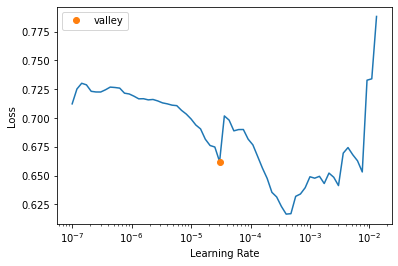

In [14]:
learn.lr_find()

In [15]:
learn.fine_tune(5, 4e-5)

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.379550,0.274480,0.905837,0.827881,33:10


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.343553,0.217423,0.933232,0.874821,34:23
1,0.296852,0.238162,0.920650,0.852967,34:24
2,0.224495,0.192349,0.937484,0.882324,34:23
3,0.231438,0.185783,0.943883,0.893729,34:19
4,0.198620,0.181935,0.943409,0.892880,34:19


In [ ]:
#learn.save('tmp_bu')

In [16]:
learn.export(f'res34_{IMG_SIZE}_j{892}_v4')